## This notebook is a demo for

1. Testing the convergence between the grf-approximated covariance matrix to the ground truth diffusion kernel.

In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
import math

In [2]:
import sys
import os
project_root = os.path.abspath("..")
sys.path.append(project_root)

In [3]:
from efficient_graph_gp.graph_kernels import fast_diffusion_grf_kernel, diffusion_kernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [4]:
# Parameters
num_nodes = 10
graph_type = 'line' # 'line', 'random'
np.random.seed(0)

In [5]:
if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix

In [6]:
ground_truth = diffusion_kernel(adj_matrix=adjacency_matrix, beta=0.1)

In [7]:
grf_matrix = fast_diffusion_grf_kernel(
    adj_matrix=adjacency_matrix,
    walks_per_node=100,
    p_halt=0.1,
    max_walk_length=20,
    beta=0.1
)

In [8]:
# Updated plotting function
def plot_heatmaps(walks_per_node_sample, p_halt_sample, beta_sample):
    # Compute Ground Truth and GRF Matrix
    ground_truth = diffusion_kernel(adjacency_matrix, beta_sample)
    grf_matrix = fast_diffusion_grf_kernel(
        adjacency_matrix,
        walks_per_node=walks_per_node_sample,
        p_halt=p_halt_sample,
        max_walk_length=100,
        beta=beta_sample
    )
    
    # Create the plots
    plt.figure(figsize=(12, 6))
    
    # Heatmap for Ground Truth
    plt.subplot(1, 2, 1)
    sns.heatmap(ground_truth, annot=True, cmap='viridis', cbar=True)
    plt.title(f"Ground Truth (Beta={beta_sample:.2f})")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    # Heatmap for GRF Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(grf_matrix, annot=True, cmap='viridis', cbar=True)
    plt.title(f"GRF Matrix (Walks Per Node={walks_per_node_sample}, p_halt={p_halt_sample:.2f})")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    plt.tight_layout()
    plt.show()

# Interactive widgets
walks_per_node_slider = widgets.IntSlider(value=20, min=10, max=1000, step=10, description='Walks Per Node:')
p_halt_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='p_halt:')
beta_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Beta:')  # New slider for beta

# Interactive output
ui = widgets.VBox([walks_per_node_slider, p_halt_slider, beta_slider])
out = widgets.interactive_output(plot_heatmaps, {
    'walks_per_node_sample': walks_per_node_slider,
    'p_halt_sample': p_halt_slider,
    'beta_sample': beta_slider
})

# Display widgets and plots
display(ui, out)

Output()

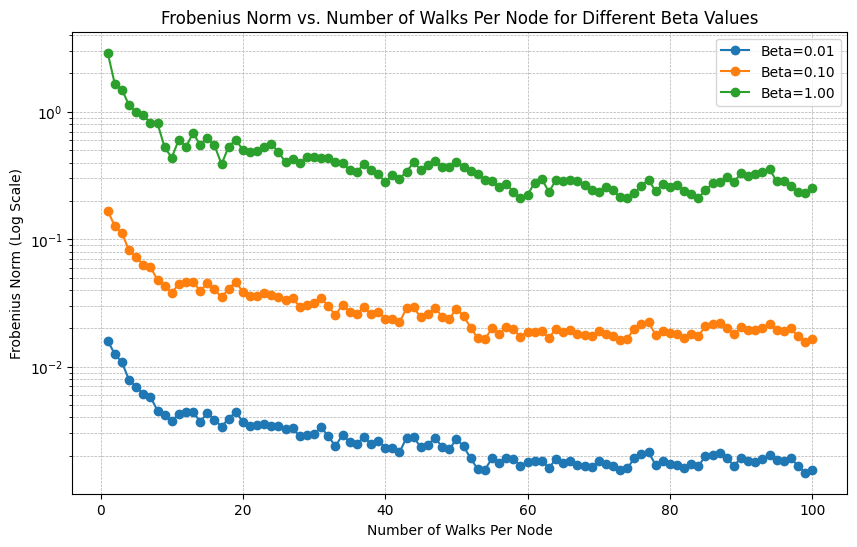

In [10]:
def plot_frobenius_norm(adjacency_matrix, p_halt, beta_values, max_walks_per_node=100):
    """
    Plot Frobenius norm vs. number of walks per node for different beta values.
    """
    ground_truths = {beta: diffusion_kernel(adjacency_matrix, beta) for beta in beta_values}
    walks_range = range(1, max_walks_per_node + 1)

    plt.figure(figsize=(10, 6))
    
    for beta in beta_values:
        norms = []
        ground_truth = ground_truths[beta]
        for walks_per_node in walks_range:
            grf_matrix = fast_diffusion_grf_kernel(adjacency_matrix,
                                                   walks_per_node,
                                                   p_halt,
                                                   max_walk_length=30,
                                                   beta=beta)
                
            # grf_matrix = grf_kernel(adjacency_matrix, walks_per_node, p_halt, 
            #                         modulation_function=diffusion_modulation_function, beta=beta)
            norm = compute_fro(ground_truth, grf_matrix)
            norms.append(norm)
        
        plt.plot(walks_range, norms, marker='o', label=f"Beta={beta:.2f}")

    # Configure plot
    plt.title("Frobenius Norm vs. Number of Walks Per Node for Different Beta Values")
    plt.xlabel("Number of Walks Per Node")
    plt.ylabel("Frobenius Norm (Log Scale)")
    plt.yscale("log")  # Use log scale for y-axis
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage
beta_values = [0.01,0.1,1]  # List of beta values to compare
plot_frobenius_norm(adjacency_matrix, p_halt=0.1, beta_values=beta_values)